In [1]:
import os
import pandas as pd 
from sentence_transformers import SentenceTransformer
import scipy.spatial.distance
import scipy
import nltk
from nltk.corpus import stopwords
from utils.functions import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from yellowbrick.text import TSNEVisualizer
import numpy as np
import swifter
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
stops = stopwords.words('english') + ["hon","member","right","friend","mr",'hon.','make','say','great']

from classification import *
import spacy 
nlp = spacy.load("en_core_web_sm")
import warnings
warnings.filterwarnings("ignore")

In [101]:
## Import annotated data
annotations = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/classifier/annotated-arguments-bureaucracy.csv')
annotations['metadata'] = ''

refdata = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/classifier/training_data_full.csv',sep='\t')
refdata['id-ann'] = [x + 594 for x in refdata.index]

for c,i in enumerate(annotations['id']):
    annotations['metadata'][c] = str(refdata[refdata['id-ann'] == i].reset_index(drop=True)['id'][0])

annotations['text'] = utils.preprocess_(annotations['text'])
annotations = annotations[["id","label","text"]]
annotations['text'] = [" ".join([w.text for w in nlp(t) if w.pos_ in ["ADJ","NOUN"] and w.text not in stops]) for t in tqdm(annotations['text'])]

labels = {1:"neutral",2:"inefficient",3:"powerful/large",4:"centralization",5:"freedom",6:"expensive",7:"anti-democratic"}
annotations['label'] = annotations['label'].astype(str)
annotations['label'] = [labels[int(x)] for x in annotations['label']]

annotations = annotations.drop_duplicates('text').reset_index(drop=True)

100%|██████████| 640/640 [00:08<00:00, 73.49it/s]


In [2]:
df = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/bureaucracy-sentences-full.tsv',sep='\t')
df.columns = ['id','text']
df['text'] = utils.preprocess_(df['text'])
df['text'] = [" ".join([w.text for w in nlp(t) if w.pos_ in ["ADJ","NOUN"] and w.text not in stops]) for t in tqdm(df['text'])]


100%|██████████| 4080/4080 [02:04<00:00, 32.74it/s]


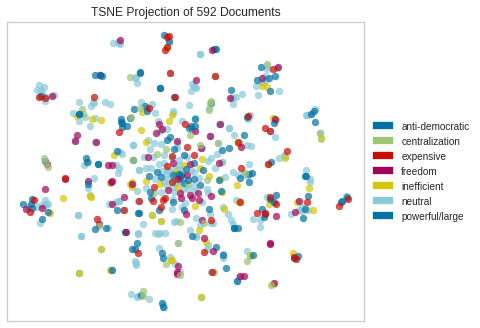

<AxesSubplot:title={'center':'TSNE Projection of 592 Documents'}>

In [42]:
# Embeddings with TFIDF
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=2500)
tfidf_vect_ngram.fit(annotations['text'])
X_tfidf = tfidf_vect_ngram.transform(annotations['text'])
Y_tfidf = annotations.label

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_tfidf, Y_tfidf)
tsne.show()

Pandas Apply: 100%|██████████| 592/592 [00:40<00:00, 14.63it/s]


<AxesSubplot:xlabel='p0', ylabel='p1'>

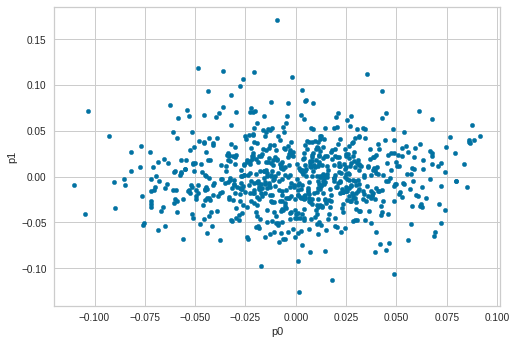

In [7]:
# Embeddings with SentenceBert
model = SentenceTransformer('bert-base-nli-mean-tokens')
vectors_swifter = annotations['text'].swifter.apply(model.encode)
annotations['sentence-bert'] = vectors_swifter
embdf = pd.DataFrame(list(vectors_swifter))

# Visualise after PCA dim. red. 
pca = PCA(n_components=2)
pca.fit(embdf)
pcadf = pd.DataFrame(pca.components_).T
pcadf.columns = ["p" + str(x) for x in pcadf.columns]
pcadf.plot.scatter(x='p0',y='p1')

Window 6


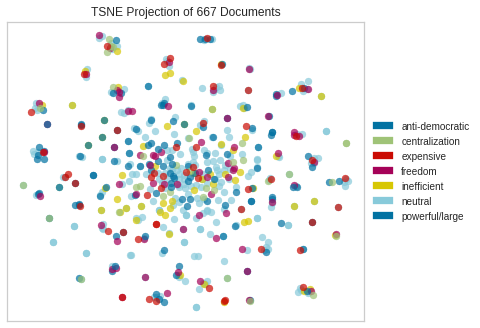

Window 8


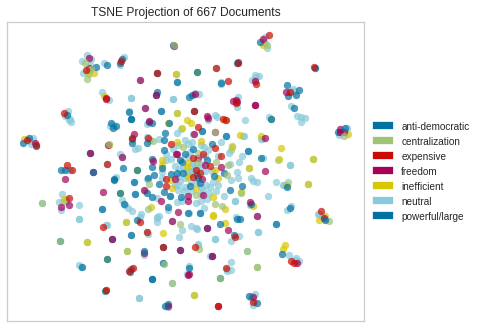

Window 12


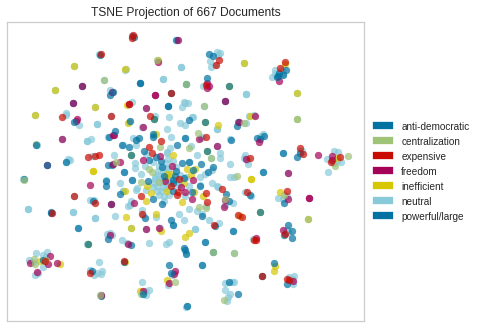

Window 16


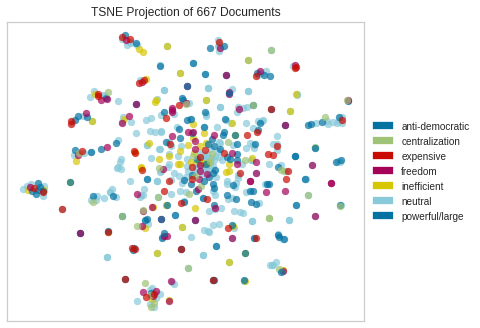

Window 24


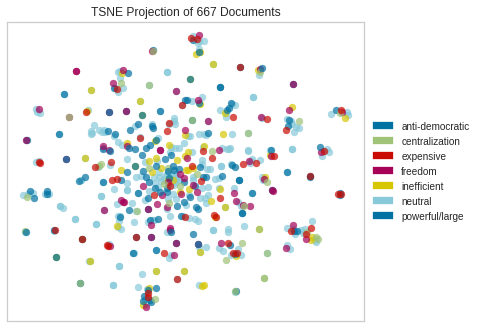

In [10]:
# Create smaller windows around bureaucracy in annotations 

for w in [6,8,12,16,24]:
    print("Window",w)
    wda = utils.windowizer(annotations,words=['bureaucracy'],window=w,id_column="label")
    wda['id'] = [x.split('-')[0] for x in wda['id']]
    wda.columns = ['label','text']
    annotations_wd = wda

    # Embeddings with TFIDF
    tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
    tfidf_vect_ngram.fit(annotations_wd['text'])
    X_tfidf = tfidf_vect_ngram.transform(annotations_wd['text'])
    Y_tfidf = annotations.label

    # Create the visualizer and draw the vectors
    tsne = TSNEVisualizer()
    tsne.fit(X_tfidf, Y_tfidf)
    tsne.show()

In [19]:
from sklearn.cluster import KMeans
df['party'] = df.id.str.split('-').str[-1]
df['year'] = df.id.str.split('-').str[1].astype(int)
df['speaker_id'] = df.id.str.split('-').str[0].astype(str)
df['date'] = df.id.str.split('.').str[0].str.split('-').str[1:].str.join('-')

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,4), max_features=2500)
tfidf_vect_ngram.fit(df['text'])
X_tfidf = tfidf_vect_ngram.transform(df['text'])


100%|██████████| 49/49 [00:05<00:00,  8.79it/s]


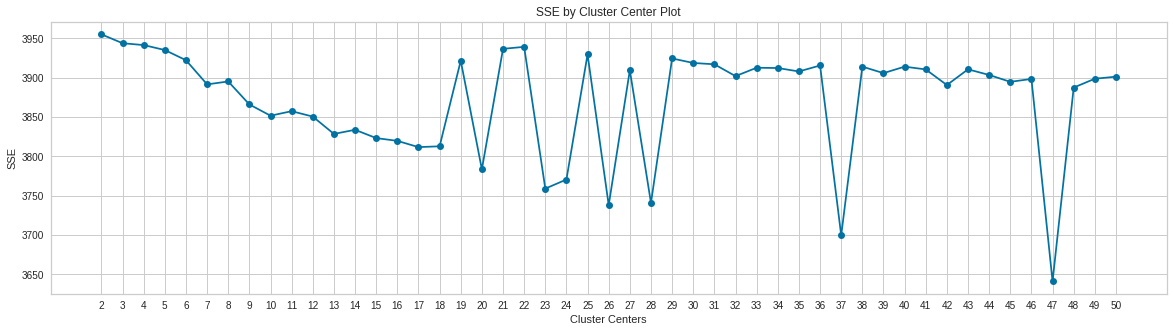

In [14]:
from sklearn.cluster import MiniBatchKMeans

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    sse = []
    for k in tqdm(iters):
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1,figsize=(20,5))
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_tfidf, 50)

In [82]:
kmeans = KMeans(n_clusters=24).fit(X_tfidf)
df['k'] = [str(x) for x in kmeans.labels_]
tfidfo, docterms = tfidf.get_docterms(df,"text")
tt = tfidf.get_topterms(tfidfo,docterms,df,'k')
#tt.head(5)

In [83]:
t = df[['k','year']]
t['n'] = 1
t = t.groupby(['k','year']).sum().reset_index().pivot(index='year',columns='k',values='n').reset_index().fillna(0)

In [86]:
t.columns = ['year'] + ["-".join(tt[c][:6]) for x,c in enumerate(list(t.columns)[1:])]

KeyError: 'local authority-authority-local-government-problem-area'

Text(0.5, 1.0, 'title')

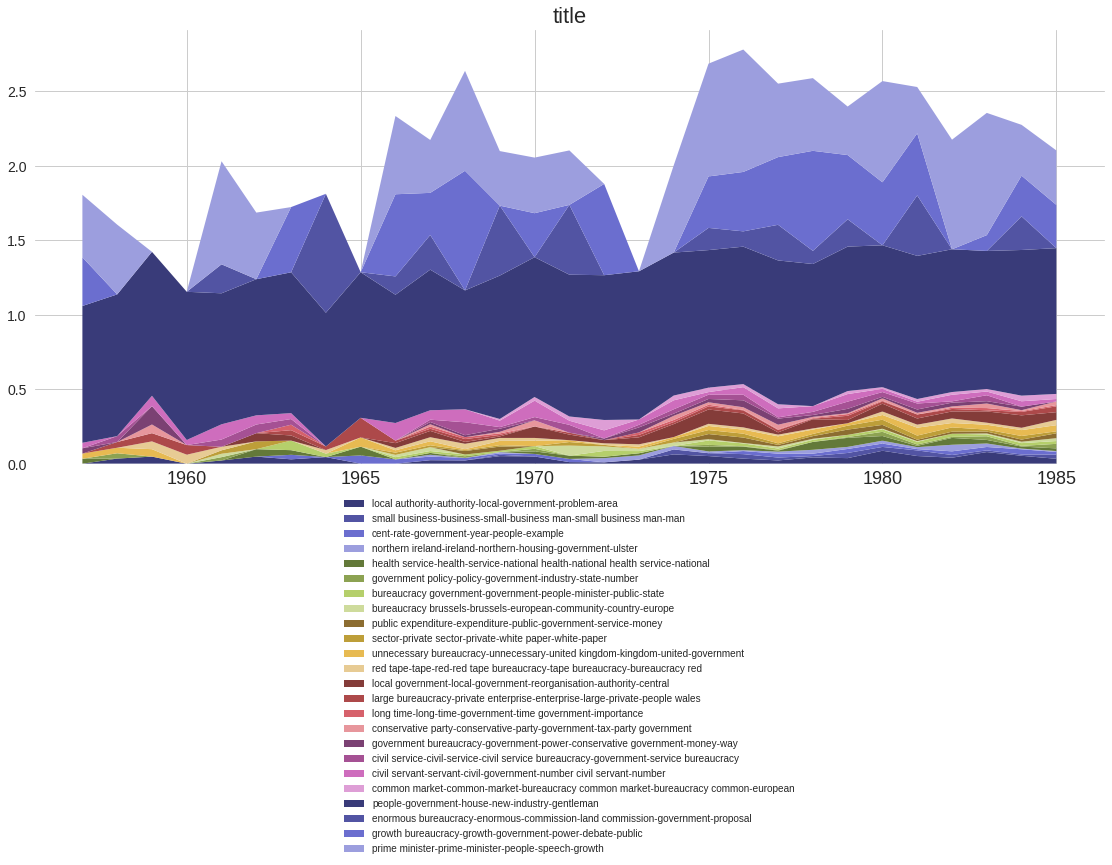

In [85]:
fig, ax = plt.subplots(facecolor='white',figsize=(24, 8))
labels = list(t.columns[1:])
plt.stackplot(list(t.year), *[t[col] for col in labels], baseline="zero", colors = sns.color_palette("tab20b", 20))
ax.set_facecolor("white")
box = ax.get_position()
#hfont = {'fontname':'Helvetica'}

ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.06))

for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
    ticks.set_color("white")
for pos in ['top', 'bottom', 'right', 'left']:
    ax.spines[pos].set_edgecolor("white")

plt.yticks(fontsize=14)
plt.xticks(fontsize=18)

plt.title('title', fontsize=22)

In [25]:
# Topic Modelling
import gensim
import gensim.corpora as corpora

def DictionaryCorpus(texts):
    # Create Dictionary
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    return id2word,corpus

In [28]:
id2word,corpus = DictionaryCorpus([s.split(' ') for s in df['text']])

In [43]:
def LDA(n_topics,id2word,corpus,texts):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,
                                               num_topics=n_topics,
                                               random_state=100,update_every=1,chunksize=100,
                                               passes=100,alpha='auto',
                                               per_word_topics=True)
    print('\t -- finished training')

    # Save top words
    top_words_per_topic = []
    for t in range(lda_model.num_topics):
        top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 15)])

    return lda_model,pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])

In [93]:
lda_model,d = LDA(36,id2word,corpus,[s.split(' ') for s in df['text']])
d = d.pivot(index='Word',columns='Topic',values='P').fillna(0).reset_index()

	 -- finished training


In [94]:
for c in list(d.columns)[1:]:
    t = d.sort_values(c,ascending=False).reset_index(drop=True)['Word'][:15]
    print(c,'\t'," ".join(t))
    print('\t----------')

0 	 small department body deal association complaint previous st manufacturer fine university harm portsmouth gobble understate
	----------
1 	 clause easy balance chancellor light lord permanent germany justifiable replacement gamut standpoint startling transplant technicality
	----------
2 	 freedom officer whitehall record mean cause poor entitle nurse voice philosophy chance port status emergency
	----------
3 	 local authority example education different effective union transport several competition age tendency minute mrs privilege
	----------
4 	 new problem british firm united economy economic kingdom requirement press affair administer equal understanding associate
	----------
5 	 business support man big young detail circumstance complex worth establish possibility piece lose face modern
	----------
6 	 housing place difficult life elect danger sense property advance rent appoint constructive message grievance spite
	----------
7 	 benefit unnecessary police use rule second c

In [95]:
 dr = []
 for c,i in enumerate(corpus):

     for x in lda_model.get_document_topics(i):
         dr.append([df['year'][c],x[0],x[1]])

In [96]:
dr = pd.DataFrame(dr,columns=['year','t','s'])
dr = dr.groupby(['year','t']).sum().reset_index()
dr = dr.pivot(index='year',columns='t',values='s').fillna(0).reset_index()
dr.columns = ['year'] + ["-".join(d.sort_values(c,ascending=False).reset_index(drop=True)['Word'][:5]) for x,c in enumerate(list(dr.columns)[1:])]

In [97]:
# for c in list(dr.columns)[1:]:
#     dr[c] = dr[c] / dr[list(dr.columns)[1:]].sum(axis=1)

Text(0.5, 1.0, 'title')

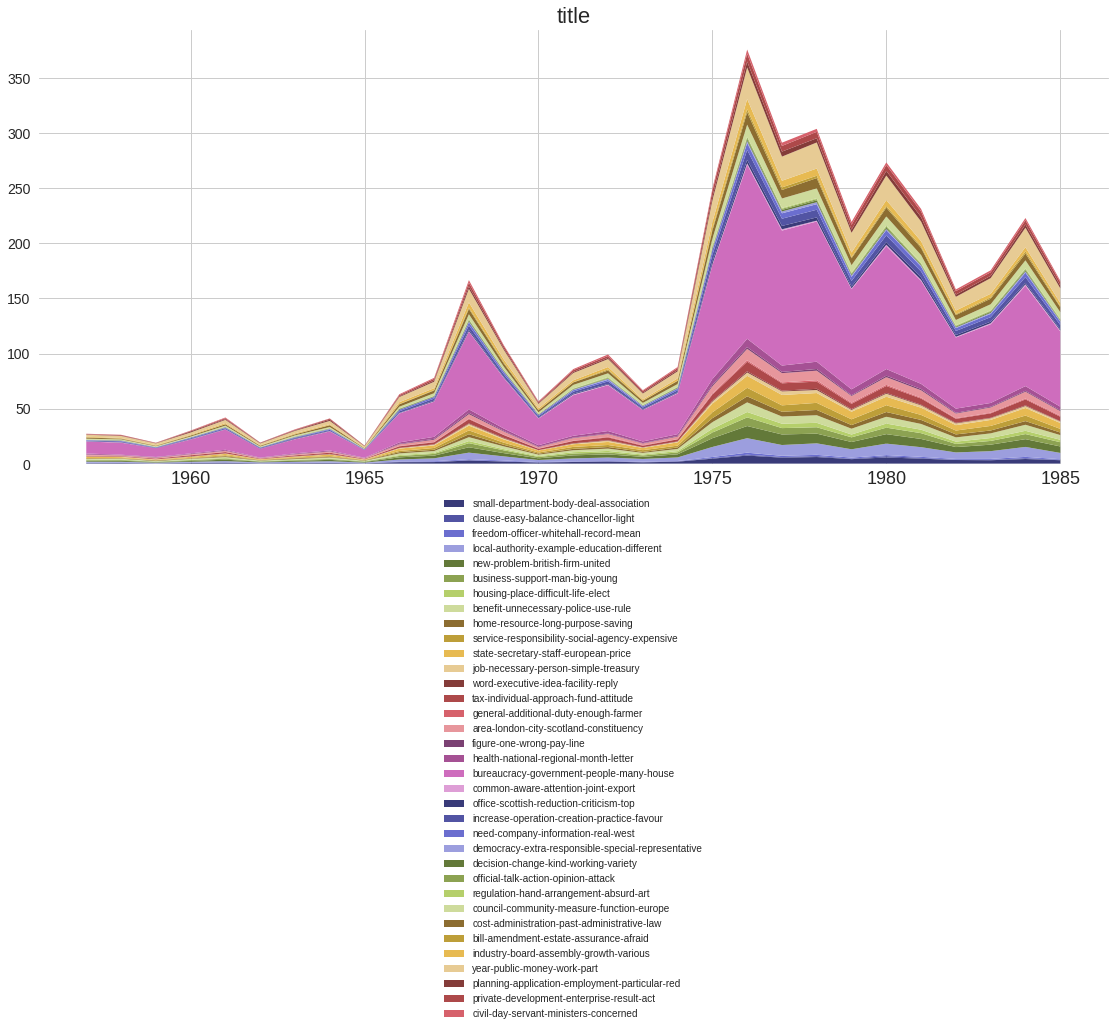

In [98]:
fig, ax = plt.subplots(facecolor='white',figsize=(24, 8))
labels = list(dr.columns[1:])
plt.stackplot(list(dr.year), *[dr[col] for col in labels], baseline="zero", colors = sns.color_palette("tab20b", 20))
ax.set_facecolor("white")
box = ax.get_position()
#hfont = {'fontname':'Helvetica'}

ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.06))

for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
    ticks.set_color("white")
for pos in ['top', 'bottom', 'right', 'left']:
    ax.spines[pos].set_edgecolor("white")

plt.yticks(fontsize=14)
plt.xticks(fontsize=18)

plt.title('title', fontsize=22)